# Assignment 3: Word2Vec

In this assignment, we will see how we can use Word2Vec (or any similar word embedding) to use information from unlabelled data to help us classify better!

You will be using the sentiment data from last week, either the yelps or movies, whichever you wish. 

Your goal will be to simulate the following situation: you have a **small** set of labelled data and a large set of unlabelled data. Show how the two follow 2 techniques compare as the amount of labelled data increases. You should train them on the small labelled subset and test their performance on the rest of the data. 

In other words, train on 1k, test on 99k. Then train on 2k, test on 98k. Then train on 4k, test on 96k. Etc.

1. Logistic regression trained on labelled data, documents represented as term-frequency matrix of your choice. You can learn the vocabulary from the entire dataset or only the labelled data.

2. Logistic regression trained on the labelled data, documents represented as word2vec vectors where you train word2vec using the entire dataset. Play around with different settings of word2vec (training window size, K-negative, skip-gram vs BOW, training windows, etc.). Note: we didn't go over the options in detail in class, so you will need to read about them a bit!

You can read about the gensime word2vec implementation [here](https://radimrehurek.com/gensim/models/word2vec.html).

In [1]:
import matplotlib.pyplot as plt
# copy - pasted from last solutions
import re
import spacy
import seaborn as sns
import pandas as pd
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import nltk as nl
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

In [58]:
stemmer = SnowballStemmer("english")
not_alphanumeric_or_space = re.compile('[^(\w|\s|\d)]')
nlp = spacy.load('en_core_web_sm')

def preprocess1(doc):
    doc = re.sub(not_alphanumeric_or_space, '', doc)
    words = [t.lemma_ for t in nlp(doc) if t.lemma_ != '-PRON-']
    return ' '.join(words).lower()

def preprocess2(doc):
    doc = re.sub(not_alphanumeric_or_space, '', doc)
    words = [t.lemma_ for t in nlp(doc) if (t.lemma_ != '-PRON-' and t.lemma_!='\n')]
    return words

In [59]:
yelps = pd.read_csv('../text-mining-2020-classifying-text-muellerm-95/sentiment/yelps.csv').sample(frac=1.)

In [60]:
yelps=yelps.sample(frac=1.)

In [61]:
yelps.shape

(100003, 3)

In [62]:
y=np.array(yelps.positive)
X=yelps.text.to_list()
df=pd.DataFrame(columns=['method','test_size','score'])
test_size_range=[0.01,0.02,0.04,0.08,0.15]
for test_size in test_size_range:

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=(1-test_size), random_state=42)
    
    # initialize vectorizer
    vectorizer = TfidfVectorizer(min_df=2,
                                 max_df=.8,
                                 preprocessor=preprocess1,
                                 stop_words='english',
                                 use_idf=False,
                                 norm=False)
    
    # transform for vectorizer
    X_train1 = vectorizer.fit_transform(X_train)
    X_test1 = vectorizer.transform(X_test)

    # logistic regr with vectorized data
    clf1=LogisticRegression(random_state=0)
    clf1.fit(X_train1,y_train)
    preds1=clf1.predict(X_test1)
    score1=sum(y_test==preds1)/len(preds1)

    # append result to df
    df=df.append({'method':'vectorizer','test_size':test_size,'score':score1},ignore_index=True)
    
    # now use word2vec
    # first preprocess
    X_train2 = [preprocess2(doc) for doc in X_train]
    X_test2 = [preprocess2(doc) for doc in X_test]
    
    # train model on full set
    docs=[preprocess2(doc) for doc in X]
    model = Word2Vec(docs, min_count=1,size=50)
    model.train(docs, total_examples=len(docs), epochs=100)
    
    # transform train and test set
#     X_train2_=np.array([])
#     for doc in X_train2:
#         X_train2_=np.append(X_train2_,[model.wv.__getitem__(word) for word in doc])
#     X_train2=X_train2_.reshape(X_train.shape)
    
#     X_test2_=np.array([])
#     for doc in X_test2:
#         X_test2_=np.append(X_test2_,[model.wv.__getitem__(word) for word in doc])
#     X_test2=X_test2_.reshape(X_test.shape)
    X_train2_=[]
    for doc in X_train2:
        docvec=np.zeros(shape=(50,))
        for word in doc:
            docvec+=model.wv.__getitem__(word)
        docvec=docvec/np.linalg.norm(docvec)
        X_train2_+=[docvec.tolist()]
    X_train2=np.asarray(X_train2_)
    
    col_mean = np.nanmean(X_train2, axis=0)
    inds = np.where(np.isnan(X_train2))
    X_train2[inds]=np.take(col_mean, inds[1])
    
    X_test2_=[]
    for doc in X_test2:
        docvec=np.zeros(shape=(50,))
        for word in doc:
            docvec+=model.wv.__getitem__(word)
        docvec=docvec/np.linalg.norm(docvec)
        X_test2_+=[docvec.tolist()]
    X_test2=np.asarray(X_test2_)
    
    col_mean = np.nanmean(X_test2, axis=0)
    inds = np.where(np.isnan(X_test2))
    X_test2[inds]=np.take(col_mean, inds[1])
    #X_train2=np.array([([model.wv.__getitem__(word) for word in doc]) for doc in X_train2])
    #X_test2=np.array([([model.wv.__getitem__(word) for word in doc]) for doc in X_test2])

    # perform logistic regression
    clf2=LogisticRegression(random_state=0)
    clf2.fit(X_train2,y_train)
    preds2=clf2.predict(X_test2)
    score2=sum(y_test==preds2)/len(preds2)
    
    # append result to df
    df=df.append({'method':'word2vec','test_size':test_size,'score':score2},ignore_index=True)

/home/maximilian/anaconda2/envs/py36/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
<ipython-input-62-a26e2d1d85ba>:70: RuntimeWarning: invalid value encountered in true_divide
  docvec=docvec/np.linalg.norm(docvec)
/home/maximilian/anaconda2/envs/py36/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
<ipython-input-62-a26e2d1d85ba>:70: RuntimeWarning: invalid value encountered in true_divide
  docvec=docvec/np.linalg.norm(docvec)
/home/maximilian/anaconda2/envs/py36/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning

In [64]:
df

,method,test_size,score
0,vectorizer,0.01,0.897165
1,word2vec,0.01,0.912094
2,vectorizer,0.02,0.911074
3,word2vec,0.02,0.925288
4,vectorizer,0.04,0.923409
5,word2vec,0.04,0.931450
6,vectorizer,0.08,0.934393
7,word2vec,0.08,0.936230
8,vectorizer,0.15,0.940567
9,word2vec,0.15,0.939249


In [65]:
vec_df=df[df.method=='vectorizer']
word_df=df[df.method=='word2vec']

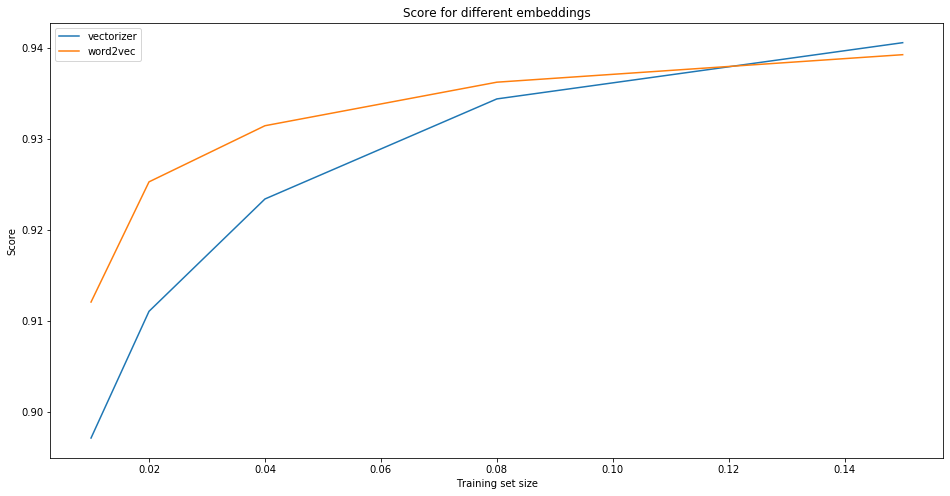

In [68]:
plt.figure(figsize=(16,8))
plt.plot(vec_df.test_size,vec_df.score,label='vectorizer')
plt.plot(word_df.test_size,word_df.score,label='word2vec')
plt.title('Score for different embeddings')
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend()